In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install onnx onnxruntime-gpu

In [1]:
labels = ['A1_구진_플라크',
          'A2_비듬_각질_상피성잔고리',
          'A3_태선화_과다색소침착',
          'A4_농포_여드름',
          'A5_미란_궤양',
          'A6_결절_종괴',
          'A7_무증상']

# onnx inference

In [2]:
import onnxruntime
from scipy.special import softmax
from PIL import Image
from torchvision.transforms import ToTensor, Normalize
import torch, os, random
import matplotlib.pyplot as plt

In [5]:
model_region = 'A'
model_name = 'efficientnet'
opt_name = 'Adam'
version = 'v1'
model_path = '/content/drive/MyDrive/NVIDIA-CVproject/models'

In [3]:
onnxruntime.get_device()

'GPU'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# filepath = os.path.join(model_path, f'{model_region}_{model_name}_{opt_name}_{version}.onnx')
filepath = '/content/drive/MyDrive/Pal-ette/CVProject/models/inception_resnet_v2_skin_pretrained.onnx'
ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name

In [7]:
if model_region == 'A':
    # for A
    mean_ = (0.5451, 0.5180, 0.5032)
    std_ = (0.1671, 0.1758, 0.1764)
elif model_region == 'B':
    mean_ = (0.5752, 0.5440, 0.5233)
    std_ = (0.1640, 0.1724, 0.1746)
elif model_region == 'H':
    mean_ = (0.5689, 0.5348, 0.5170)
    std_ = (0.1897, 0.1946, 0.1960)
elif model_region == 'L':
    # for L
    mean_ = (0.5522, 0.5198, 0.5022)
    std_ = (0.2244, 0.2015, 0.1933)

In [13]:
def inference_simple(img_path):

    img = Image.open(img_path)
    # img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0)
    # img = Normalize(mean_, std_)(img).unsqueeze(0)

    ort_inputs = {input_name: img.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)

    result = softmax(ort_outs)
    return (result[0][0].argmax(), result[0][0].tolist())

In [27]:
if not os.path.exists(f'/content/test_{model_region}'):
    os.makedirs(f'/content/test_{model_region}')

In [28]:
os.environ['test_filepath'] = f'/content/test_{model_region}'
os.environ['test_filename'] = f'/content/drive/MyDrive/NVIDIA-CVproject/test_{model_region}.zip'

In [8]:
if not os.path.exists(f'/content/test'):
    os.makedirs(f'/content/test')

In [9]:
!unzip -qq /content/drive/MyDrive/NVIDIA-CVproject/test_dog_resized.zip -d /content/test

In [6]:
root = f'/content/test' # _{model_region}'

for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))

A3_태선화_과다색소침착 6746
A1_구진_플라크 4068
A2_비듬_각질_상피성잔고리 7849
A5_미란_궤양 1500
A4_농포_여드름 1668
A7_무증상 17401
A6_결절_종괴 1514


In [ ]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        predictions['target'].append(int(folder[1])-1)
        inf_result = inference_simple(os.path.join(root, folder, file))
        predictions['pred'].append(inf_result[0])
        predictions['probs'].append(inf_result[1])

        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

In [15]:
from collections import Counter

Counter(predictions['target'])

Counter({2: 6746, 0: 4068, 1: 7849, 4: 1500, 3: 1668, 6: 17401, 5: 1514})

In [16]:
Counter(predictions['pred'])

Counter({4: 1765, 2: 5317, 1: 9119, 6: 18130, 5: 1899, 0: 3155, 3: 1361})

In [17]:
preds = list(map(int, predictions['pred'])) # to save json
predictions['pred'] = preds

In [18]:
import json
# {model_region}-{model_name}_{opt_name}_{version}
with open(f'/content/drive/MyDrive/NVIDIA-CVproject/prediction/irv2.json', 'w') as f:
    json.dump(predictions, f)

In [19]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, 'A1_구진_플라크'),
 Text(0, 1.5, 'A2_비듬_각질_상피성잔고리'),
 Text(0, 2.5, 'A3_태선화_과다색소침착'),
 Text(0, 3.5, 'A4_농포_여드름'),
 Text(0, 4.5, 'A5_미란_궤양'),
 Text(0, 5.5, 'A6_결절_종괴'),
 Text(0, 6.5, 'A7_무증상')]

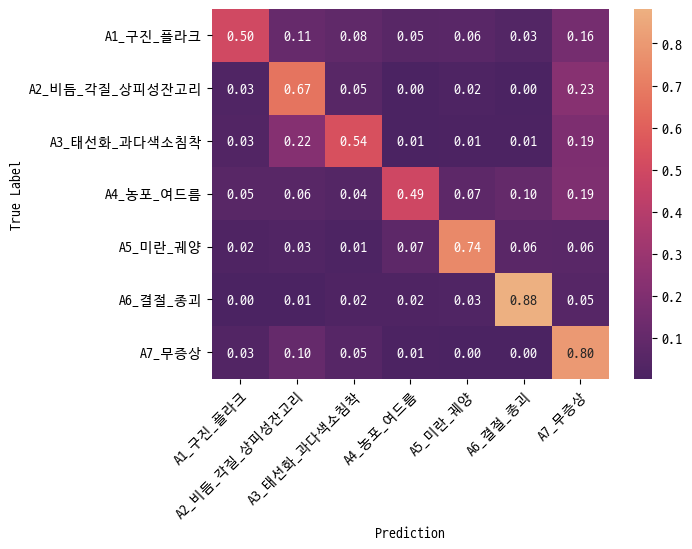

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [21]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

           0       0.65      0.50      0.57      4068
           1       0.58      0.67      0.62      7849
           2       0.68      0.54      0.60      6746
           3       0.60      0.49      0.54      1668
           4       0.63      0.74      0.68      1500
           5       0.70      0.88      0.78      1514
           6       0.77      0.80      0.78     17401

    accuracy                           0.69     40746
   macro avg       0.66      0.66      0.65     40746
weighted avg       0.69      0.69      0.69     40746



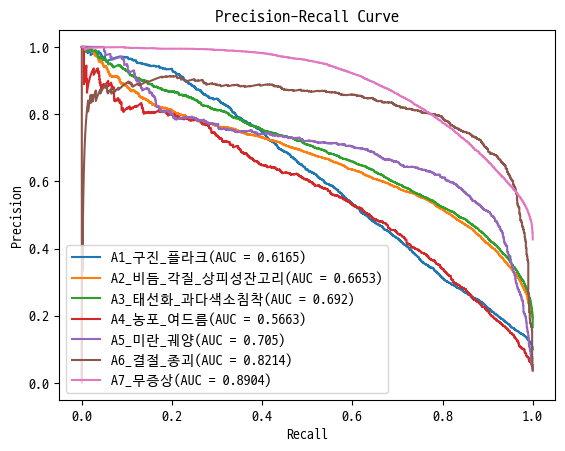

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

legend = []

for i in range(len(labels)):
    target = np.array(predictions['target'])==i
    target = target.astype(int)
    probs = np.array(predictions['probs'])[:, i]

    precision, recall, thresholds = precision_recall_curve(target, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision)
    legend.append(labels[i] + '(AUC = ' + str(round(pr_auc,4)) + ')')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(legend, loc='lower left')
plt.show()